<a href="https://colab.research.google.com/github/zahraDehghanian97/stock_market/blob/master/Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import GRU
from keras.layers import LSTM , Dense
from keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import glob
import warnings
from sklearn.metrics import mean_squared_error , confusion_matrix
from statsmodels.tsa.arima_model import ARIMA
import datetime as dt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler , MinMaxScaler



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
! curl -L https://api.github.com/repos/zahraDehghanian97/stock_market/tarball --output repo.tar
! tar xf repo.tar --wildcards "*/tickers_data/*.csv" --strip-components=1 
! rm -rf repo.tar


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 15.5M    0 15.5M    0     0  6990k      0 --:--:--  0:00:02 --:--:-- 5808k


In [4]:
def load_df_from_csv(dir_name:str) -> dict:
  stocks = {}
  for file_name in sorted(glob.glob(dir_name+'/*.csv')):
    df = pd.read_csv(file_name,names=['close'])
    dataset_name = file_name.split("/")[1].split(".csv")[0]
    print(dataset_name)
    stocks[dataset_name] = df
  return stocks

stocks = load_df_from_csv(dir_name="tickers_data")

def evaluate_performance(testing_actual, testing_predict):
    counter = 0
    for i in range(len(testing_actual)-1):
        predict=testing_predict[i+1]- testing_predict[i]
        actual = testing_actual[i+1]-testing_actual[i]
        if (actual > 0 and predict > 0) or (actual < 0 and predict < 0):
            counter+=1
    counter = round((counter / (len(testing_actual)-1))*100,2)
    return counter


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


prices_stock_yahoo
خچرخش
شپنا


LSTM Model

In [13]:
def LSTM_model (X_train,y_train,load_model):
  if load_model :
    # load model
    model = load_model("{}.h5".format(model_name))
    print("MODEL-LOADED")
  else :
    model_name = 'LSTM'
    model = Sequential()
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (1, 4)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.fit(X_train, y_train, epochs = 250, batch_size = 50 ,validation_split=0.1, verbose=0)
    model.save("{}.h5".format(model_name))
    print('MODEL-SAVED')
  return model






MODEL-SAVED
24/24 [==============================] - 0s 2ms/step - loss: 0.0255
Score: 0.025507057085633278
-------------------------------
evaluating performance...
Testing Accuracy:  32.57 %
Prediction for today:  -1


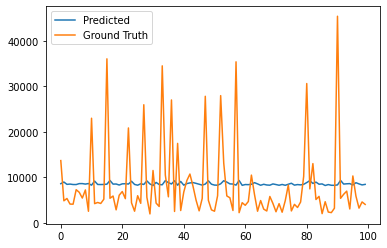

In [14]:
prices = pd.read_csv('tickers_data/شپنا.csv', index_col=['date'])
prices = prices[[ 'open', 'high', 'low', 'close']]
# preparing label data
prices_shift = prices.shift(-1)
label = prices_shift['close']

# adjusting the shape of both
prices.drop(prices.index[len(prices)-1], axis=0, inplace=True)
label.drop(label.index[len(label)-1], axis=0, inplace=True)

# conversion to numpy array
x, y = prices.values, label.values
# scaling values for model
x_scale = MinMaxScaler()
y_scale = MinMaxScaler()
X = x_scale.fit_transform(x)
Y = y_scale.fit_transform(y.reshape(-1,1))
# splitting train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
X_train = X_train.reshape((-1,1,4))
X_test = X_test.reshape((-1,1,4))
# change today result with tomorrow to lean param tomorrow
X_train = X_train [:-1]
y_train = y_train[1:]
y_test = y_test[1:]
model = LSTM_model(X_train,y_train , False)
x_test = X_test[:-1]
score = model.evaluate(x_test, y_test)
print('Score: {}'.format(score))
yhat = model.predict(X_test)
if yhat[-1]>yhat[-2] :
   prediction_today = 1
else : 
  prediction_today = -1
yhat = yhat [:-1]
print("-------------------------------")
print('evaluating performance...')
accuracy_model = evaluate_performance(y_test, yhat)
print('Testing Accuracy: ', accuracy_model,"%")

print('Prediction for today: ', prediction_today)

yhat = y_scale.inverse_transform(yhat)
y_test = y_scale.inverse_transform(y_test)
plt.plot(yhat[-100:], label='Predicted')
plt.plot(y_test[-100:], label='Ground Truth')
plt.legend()
plt.show()

RNN Model

In [ ]:
def RNN_model (X_train,y_train,load_model):
  if load_model :
    # load model
    model = load_model("{}.h5".format(model_name))
    print("MODEL-LOADED")
  else :
    # build model
    model_name = 'stock_price_GRU'
    model = Sequential()
    model.add(GRU(units=512,return_sequences=True,input_shape=(1, 4)))
    model.add(Dropout(0.2))
    model.add(GRU(units=256))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train,y_train,batch_size=250, epochs=50, validation_split=0.1, verbose=0)
    model.save("{}.h5".format(model_name))
    print('MODEL-SAVED')
  return model


MODEL-SAVED
24/24 [==============================] - 0s 6ms/step - loss: 0.0308
Score: 0.030810704454779625
-------------------------------
evaluating performance...
Testing Accuracy:  66.76 %
Prediction for today:  -1


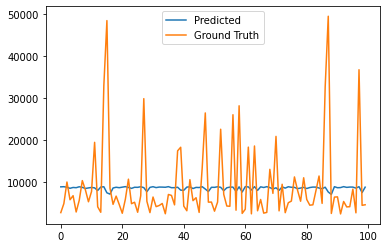

In [ ]:
# prices = pd.read_csv('tickers_data/prices_stock_prices.csv', index_col=['date'])
prices = pd.read_csv('tickers_data/شپنا.csv', index_col=['date'])

# preparing input features
prices = prices.drop(['volume'], axis=1)
prices = prices[['open', 'low', 'high', 'close']]

# preparing label data
prices_shift = prices.shift(-1)
label = prices_shift['close']

# adjusting the shape of both
prices.drop(prices.index[len(prices)-1], axis=0, inplace=True)
label.drop(label.index[len(label)-1], axis=0, inplace=True)

# conversion to numpy array
x, y = prices.values, label.values
# scaling values for model
x_scale = MinMaxScaler()
y_scale = MinMaxScaler()
X = x_scale.fit_transform(x)
Y = y_scale.fit_transform(y.reshape(-1,1))
# splitting train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
X_train = X_train.reshape((-1,1,4))
X_test = X_test.reshape((-1,1,4))
# change today result with tomorrow to lean param tomorrow
X_train = X_train [:-1]
y_train = y_train[1:]
y_test = y_test[1:]

model = RNN_model (X_train,y_train,False)

x_test = X_test[:-1]
score = model.evaluate(x_test, y_test)
print('Score: {}'.format(score))

yhat = model.predict(X_test)
if yhat[-1]>yhat[-2] :
   prediction_today = 1
else : 
  prediction_today = -1
yhat = yhat [:-1]
print("-------------------------------")
print('evaluating performance...')
accuracy_model = evaluate_performance(y_test, yhat)
print('Testing Accuracy: ', accuracy_model,"%")

print('Prediction for today: ', prediction_today)

yhat = y_scale.inverse_transform(yhat)
y_test = y_scale.inverse_transform(y_test)
plt.plot(yhat[-100:], label='Predicted')
plt.plot(y_test[-100:], label='Ground Truth')
plt.legend()
plt.show()

ARIMA MOdel

loading the dataset...
splitting training and testing set...
building and training model...
run ARIMA model
predicting...
---------------------------
The prediction for the next day: [11470.03055731]
last result = -1
---------------------------
evaluating performance...
Testing Accuracy:  61.8 %
------------------------
plotting the graph...


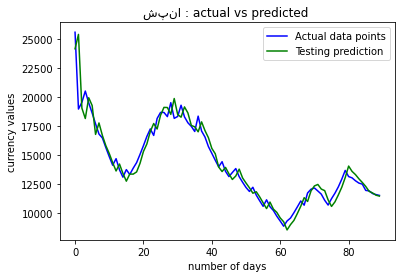

done...


In [ ]:
TRAINING_PERCENTAGE = 0.7
TESTING_PERCENTAGE = 1 - TRAINING_PERCENTAGE
NUMBER_OF_PREVIOUS_DATA_POINTS = 3
LENGTH_DATA_SET = 0
TRAINING_SET_LENGTH = 0
TESTING_SET_LENGTH = 0



def get_data(name_Stock,number_of_days):
  df = stocks[name_Stock]
  close_data = df.close.values.tolist()
  len_data = len(close_data)-1
  close_data = close_data[len_data-number_of_days:len_data]
  new_data = []
  for i in range(len(close_data)):
    new_data.append(float(close_data[i]))
  return new_data

def training_testing_buckets(raw_data, training_percentage, testing_percentage):
    global TRAINING_SET_LENGTH, TESTING_SET_LENGTH
    TRAINING_SET_LENGTH = int(LENGTH_DATA_SET * training_percentage)
    TESTING_SET_LENGTH = LENGTH_DATA_SET - TRAINING_SET_LENGTH
    training_set, testing_set = raw_data[0:TRAINING_SET_LENGTH], raw_data[TRAINING_SET_LENGTH:LENGTH_DATA_SET]
    return training_set, testing_set

    
def evaluate_performance(testing_actual, testing_predict):
    counter = 0
    for i in range(len(testing_actual)-1):
        predict=testing_predict[i+1]- testing_predict[i]
        actual = testing_actual[i+1]-testing_actual[i]
        if (actual > 0 and predict > 0) or (actual < 0 and predict < 0):
            counter+=1
    counter = round((counter / (len(testing_actual)-1))*100,2)
    return counter


def plot_model(currency, testing_actual, testing_predict):
    actual = plt.plot(testing_actual, label="Actual data points", color="blue")
    testing = plt.plot(testing_predict, label="Testing prediction", color="green")
    plt.ylabel('currency values')
    plt.xlabel('number of days')
    plt.title( currency + ' : actual vs predicted ')
    plt.legend()
    plt.show()

    # def load_data_set(currency):
    # tse.download(symbols=stock_name)
    # ticker = tse.Ticker(stock_name)
    # data = ticker.history
    # raw_data = data.close.values.tolist()
    # global LENGTH_DATA_SET
    # LENGTH_DATA_SET = len(raw_data)
    # return raw_data


def build_model_predict_arima(training_set, testing_set):
    testing_predict = list()
    training_predict = list(training_set)
    for testing_set_index in range(TESTING_SET_LENGTH):
        arima = ARIMA(training_predict, order=(5, 1, 0))
        arima_model = arima.fit(disp=0)
        forecasting = arima_model.forecast()[0].tolist()[0]
        testing_predict.append(forecasting)
        training_predict.append(testing_set[testing_set_index])
        # print("Predicted = ", testing_predict[-1], "Expected = ", testing_set[testing_set_index])
    print('predicting...')
    print("---------------------------")
    forcast = arima_model.forecast()[0]
    print('The prediction for the next day:', forcast)
    if forcast- testing_set[-1] > 0 : print("last result = +1")
    else :  print("last result = -1")
    print("---------------------------")
    return testing_predict

    
def run_model(currency,type):
    global LENGTH_DATA_SET
    print('loading the dataset...')
    # raw_data = load_data_set(currency)
    raw_data = get_data(currency,300)
    LENGTH_DATA_SET = len(raw_data)

    print('splitting training and testing set...')
    training_actual, testing_actual = training_testing_buckets(raw_data, TRAINING_PERCENTAGE, TESTING_PERCENTAGE)

    print('building and training model...')
    if type == 1 :
      print("run ARIMA model")
      testing_predict = build_model_predict_arima(training_actual, testing_actual)

    print('evaluating performance...')
    accuracy_model = evaluate_performance(testing_actual, testing_predict)
    print('Testing Accuracy: ', accuracy_model,"%")

    print("------------------------")
    print('plotting the graph...')
    plot_model(currency, testing_actual, testing_predict)

    print('done...')
    return raw_data, testing_predict
if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    # stock_name = input('Enter stock name:')
    stock_name = 'شپنا'
    type = 1 #if type = 1 arima    type=2 lstm      type=3 RNN
    run_model(stock_name,type)  # setting the entry point
